In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:01<00:00, 94.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


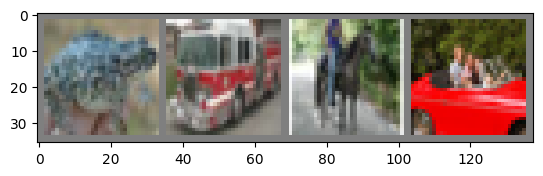

frog  truck horse car  


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv_1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv_2 = nn.Conv2d(6, 16, 5)
        self.fc_1 = nn.Linear(16 * 5 * 5, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = self.pool(x)
        x = F.relu(self.conv_2(x))
        x = self.pool(x)
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = self.fc_3(x)
        return x

model = CNN().to(device)

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [6]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.189
[1,  4000] loss: 1.829
[1,  6000] loss: 1.666
[1,  8000] loss: 1.561
[1, 10000] loss: 1.507
[1, 12000] loss: 1.430
[2,  2000] loss: 1.376
[2,  4000] loss: 1.351
[2,  6000] loss: 1.343
[2,  8000] loss: 1.281
[2, 10000] loss: 1.271
[2, 12000] loss: 1.253
Finished Training


In [7]:
PATH = './pt_cifar10_clf.pth'
torch.save(model.state_dict(), PATH)

In [8]:
# Test the network on test data

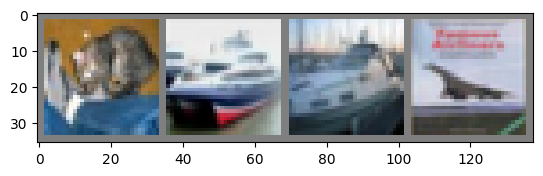

GroundTruth:  cat   ship  ship  plane


In [9]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [13]:
new_model = CNN().to(device)
new_model.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [15]:
outputs = new_model(images.to(device))

In [16]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  plane


In [17]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data

        # Move images and labels to the same device as the model
        images = images.to(device)
        labels = labels.to(device)

        # calculate outputs by running images through the network
        outputs = new_model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 55 %


In [18]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data

        # Move images and labels to the same device as the model
        images = images.to(device)
        labels = labels.to(device)

        outputs = new_model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 75.6 %
Accuracy for class: car   is 70.0 %
Accuracy for class: bird  is 32.3 %
Accuracy for class: cat   is 24.8 %
Accuracy for class: deer  is 36.1 %
Accuracy for class: dog   is 70.3 %
Accuracy for class: frog  is 58.9 %
Accuracy for class: horse is 56.5 %
Accuracy for class: ship  is 58.9 %
Accuracy for class: truck is 67.1 %


In [19]:
del dataiter